<a href="https://colab.research.google.com/github/steelpl/snr-opt/blob/main/Jupyter%20Notebook/SNRopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SNR-opt
This is a notebook for sharing python code that was used in the research paper:

> S. Kim, A. Sharma, Y. Y. Liu and S. I. Young, "Rethinking Satellite Data Merging: From Averaging to SNR Optimization," in IEEE Transactions on Geoscience and Remote Sensing, vol. 60, pp. 1-15, 2022, Art no. 4405215, doi: http://dx.doi.org/10.1109/TGRS.2021.3107028

*  If you use the methods described in the paper or in the example provided in this repository, please cite the paper appropriately. For more information, please refer to the [README](https://github.com/steelpl/snr-opt).

## Functions

In [1]:
def dataGEN(n, p, ecc, SNRdB):
    """
    This function is to generate orthogonal y and e
    
    Parameters:
    n: int, data length
    p: int, number of datasets
    ecc: float, error cross-correlation [0,1]
    SNRdB: float, signal-to-noise ratio in dB
    
    Returns:
    y: ndarray of shape (n,), signal
    e: ndarray of shape (n,p), error
    """
    
    # Estimation
    SNR = 10**(SNRdB/10)
    b = np.array(np.where(np.triu(np.ones((p,p)),1))).T  # combination pairs
    
    # Error covarance matrix: EeeT
    EeeT = np.diag(np.random.rand(p))  # error variances
    for i in range(b.shape[0]):
        EeeT[b[i,0], b[i,1]] = np.sqrt(EeeT[b[i,0], b[i,0]]*EeeT[b[i,1], b[i,1]])*ecc
        EeeT[b[i,1], b[i,0]] = EeeT[b[i,0], b[i,1]]
    
    # Generating y and e
    Ey2 = np.mean(np.diag(EeeT)*SNR)  # Signal power based on given SNR and EeeT
    
    m = np.zeros((p+1,p+1))  # covariance matrix of [y, e]
    m[0,0] = Ey2
    m[1:,1:] = EeeT
    
    ye = np.random.randn(n, p+1)  # [y, e]
    ye = ye - np.mean(ye, axis=0)  # mean removal
    cov = np.cov(ye.T)  # compute covariance matrix of transposed array
    cholesky_cov = np.linalg.cholesky(cov)  # Cholesky decomposition of covariance matrix
    ye = ye @ np.linalg.inv(cholesky_cov).T  # normalize by inverse of Cholesky decomposition of covariance matrix
    ye = ye @ np.linalg.cholesky(m)  # multiply by Cholesky decomposition of m
    
    y = ye[:,0]
    e = ye[:,1:]
    
    return y, e

def WA(EeeT):
    """
    This function is to estimate weight for Weighted Average

    Parameters:
    EeeT (ndarray): error covariance matrix (p x p)

    Returns:
    u (ndarray): merging weight (p x 1)
    """
    eta = np.ones((EeeT.shape[1], 1))
    u = np.linalg.inv(EeeT) @ eta / (eta.T @ np.linalg.inv(EeeT) @ eta)

    return u

def SNRopt(N, a):
    """
    This function is to estimate weight for SNRopt
    
    Parameters
    ----------
    N : numpy.ndarray
        noise-to-signal ratio matrix of shape (p,p)
    a : numpy.ndarray
        scaling factor of shape (p,1)
        
    Returns
    -------
    u : numpy.ndarray
        merging weight of shape (p,1)
    """
    
    # Estimation
    u = np.linalg.inv(N + np.outer(a, a)) @ a
    
    return u

def maxR(a, ExxT):
    """
    This function is to estimate weight for maximizing Pearson R

    INPUTS:
        a    : scaling factor (px1), equivalent to use a = theta; a = rho.*std(x)'
        ExxT : covariance matrix (pxp) of the data
    
    OUTPUT:
        u    : merging weight (px1)
    """

    # Generalized Rayleigh quotient
    # A*u = lamda*B*u
    A = np.outer(a, a)
    B = ExxT

    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(B) @ A)
    u = eigvecs[:, np.argmax(eigvals)]
    u = u / np.sum(u)  # normalizing sum to 1

    return u

def ECVest(ExxT):
    """
    This function is a modified version of SNRest to estimate TC-like results

    INPUT
      ExxT: covariance matrix of x (pxp)

    OUTPUT 
      EeeT_est: estimated error covariance matrix (pxp)
      theta_est: estimated theta (px1, = a*sqrt(Ey2))
      rho2_est: estimated squared data-truth correlation (px1)    
    """
    # Parameters
    p = ExxT.shape[0] # number of products
    beta = 0.5*np.min(np.diag(ExxT)) # tuning parameter for itial a (should be < any of ExxT diagonals)
    # beta = 0.1 # tuning parameter for unitializing a (should be < any of ExxT diagonals)
    lamda = 0.01 # learning rate
    iters = 2000 # number of iterations

    # Initialization
    D, V = np.linalg.eig(ExxT - beta * np.eye(p)) # D: eigenvalues; V: eigenvectors (columns)
    max_idx = np.argmax(D)
    theta_est = V[:, max_idx] * np.sqrt(D[max_idx])  # initialize theta
    theta_est = theta_est * np.sign(theta_est)  # assuming '+' sign'
    theta_init = theta_est.copy()

    # Iteration
    for i in range(iters):
        grad = np.zeros((p,), dtype=ExxT.dtype)
        for j in range(p):
            for k in range(p):
                grad[j] = grad[j] + (j!=k) * theta_est[k]*np.sign(theta_est[j]*theta_est[k] - ExxT[j,k])
        # descent
        theta_est = theta_est - (lamda/np.linalg.norm(theta_init))*grad
        # project
        theta_est = theta_est - np.sign(theta_est) * np.sqrt(np.maximum((theta_est**2 - np.diag(ExxT)),0))

    EeeT_est = ExxT - np.outer(theta_est,theta_est)
    rho2_est = (theta_est**2)/np.diag(ExxT)

    return EeeT_est, theta_est, rho2_est

def SNRest(ExxT, Ey2):
    """
    This function is for estimating N and a
    
    INPUT:
        ExxT: covariance matrix of x (pxp)
        Ey2: signal power (scalar)
        
    OUTPUT:
        N_est: estimated noise-to-signal ratio (pxp)
        a_est: estimated scaling factor (px1)
    """
    
    # Parameters
    C = ExxT / Ey2
    P = C.shape[0] # number of products
    beta = 0.5 * np.min(np.diag(C)) # tuning parameter for itial a (should be < any of C diagonals)
    # beta = 0.1 # tuning parameter for unitializing a (should be < any of C diagonals)
    lamda = 0.01 # learning rate
    iters = 2000 # number of iterations
    
    # Initialization
    eigenvalues, eigenvectors = np.linalg.eig(C - beta * np.eye(P))
    a_est = eigenvectors[:, -1] * np.sqrt(eigenvalues[-1]) # initialize a
    a_est = a_est * np.sign(a_est) # assuming '+' sign'
    a_init = a_est
    
    # Iterations
    for i in range(iters):
        grad = np.zeros(P)
        for j in range(P):
            for k in range(P):
                grad[j] += (j != k) * a_est[k] * np.sign(a_est[j] * a_est[k] - C[j, k])
        # descent
        a_est = a_est - (lamda / np.linalg.norm(a_init)) * grad
        # project
        a_est = a_est - np.sign(a_est) * np.sqrt(np.maximum(a_est ** 2 - np.diag(C), 0))
    
    N_est = C - np.outer(a_est, a_est)

    return N_est, a_est


## Code

+ Metrics for original data
 * MSE for x: 0.708
 * R2 for x: 0.3

+ Metrics for merged data by 'true' parameters
 * MSE for WA, SNRopt, maxR, EW: [0.507 0.399 0.539 0.491]
 * R2 for WA, SNRopt, maxR, EW: [0.204 0.308 0.308 0.247]

+ Metrics for merged data by 'estimated' parameters
 * MSE for WA, SNRopt, maxR, EW: [0.475 0.409 0.5   0.491]
 * R2 for WA, SNRopt, maxR, EW: [0.261 0.293 0.293 0.247]


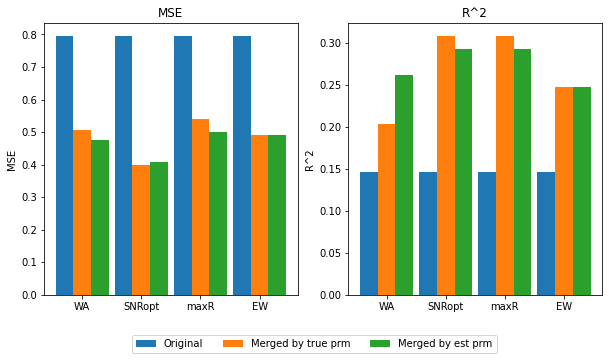

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

np.random.seed(123)

## Step 1: Data parameters
p = 3 # number of datasets
n = 1000 # data length
eta = np.ones(p)
np.random.seed(123)

######## scaling factor (a)##########
a = np.random.rand(p) # non-1-vector (for test)
a = a.reshape(-1, 1)  # reshape a to (3, 1)
######################################

ecc = 0.3 # error cross-correlation [0,1]
SNRdB = 0.1 # SNR in dB

## Step 2: Synthetic data generation
# Signal and error: y and e
y, e = dataGEN(n, p, ecc, SNRdB)
y = y.reshape(-1, 1)

# Observation: x = a*signal + error
x = np.dot(y, a.T) + e

# Signal power and covariance matrices of e and x
Ey2 = np.var(y)
EeeT = np.cov(e.T)
ExxT = np.cov(x.T)
N = EeeT/Ey2 # error-to-signal ratio

# Functions of MSE and R2 by linear combination using u
MSE = lambda u: u.T @ ExxT @ u - 2*Ey2*u.T @ a + Ey2
R2 = lambda u: Ey2*((u.T @ (a@a.T) @ u)/(u.T @ ExxT @ u))

# RMSE of observations
MSE_ori = np.diag(MSE(np.eye(p)))[:,np.newaxis]
# MSE_ori = np.mean((y-x)**2)

# Pearson correlation of observations
R2_ori = np.diag(R2(np.eye(p)))[:,np.newaxis] 

# Printing metrics
print('+ Metrics for original data')
print(' * MSE for x:', round(float(MSE_ori[0]), 3))
print(' * R2 for x:', round(float(R2_ori[0]), 3))


# Step 3: Merging using true parameters
# merging by three methods
uw = WA(EeeT)
yw = x @ uw  # weighted average
us = SNRopt(N, a)
ys = x @ us  # SNR-opt
ur = maxR(a, ExxT)
yr = x @ ur  # maxR weight
ue = 1/p * np.ones((p, 1))
ye = x @ ue  # equal weight
s = np.diag(((eta.T @ linalg.solve(EeeT, eta)) / (1/Ey2 + a.T @ linalg.solve(EeeT, a))) * a)  # us = s * uw (eq. 9)

# RMSE of data merged by true parameters
MSE_true = np.diag(MSE(np.column_stack((uw, us, ur, ue)))).T
# MSE_true = np.mean((y - np.column_stack((yw, ys, yr, ye)))**2, axis=0)

# Pearson correlation of data merged by true parameters
R2_true = np.diag(R2(np.column_stack((uw, us, ur, ue)))).T
# R2_true = np.square(np.corrcoef(y, np.column_stack((yw, ys, yr, ye)), rowvar=False)[0, 1:])

# Printing metrics
print("\n+ Metrics for merged data by 'true' parameters")
print(f" * MSE for WA, SNRopt, maxR, EW: {np.round(MSE_true, 3)}")
print(f" * R2 for WA, SNRopt, maxR, EW: {np.round(R2_true, 3)}")

# Step 4: Merging using estimated parameters
# Estimation of merging statistics
Ey2_est = Ey2 * 0.5
EeeT_est, theta_est, rho2_est = ECVest(ExxT)
N_est, a_est = SNRest(ExxT, Ey2_est)

# merging by three methods
uw_est = WA(EeeT_est)
yw_est = x @ uw_est
us_est = SNRopt(N_est, a_est)
ys_est = x @ us_est
ur_est = maxR(a_est, ExxT)
yr_est = x @ ur_est
s_est = np.diag(((eta.T @ linalg.solve(EeeT, eta)) / (1 / Ey2 + a_est.T @ linalg.solve(EeeT, a_est))) * a_est)

# RMSE of data merged by estimated parameters
MSE_est = np.diag(MSE(np.column_stack((uw_est, us_est, ur_est, ue)))).T

# Pearson correlation of data merged by estimated parameters
R2_est = np.diag(R2(np.column_stack((uw_est, us_est, ur_est, ue)))).T

# Printing metrics
print("\n+ Metrics for merged data by 'estimated' parameters")
print(f" * MSE for WA, SNRopt, maxR, EW: {np.round(MSE_est, 3)}")
print(f" * R2 for WA, SNRopt, maxR, EW: {np.round(R2_est, 3)}")

# Step 5: Plotting merging results
MSE_results = np.vstack((np.mean(MSE_ori) * np.ones((1, 4)), MSE_true, MSE_est))
R2_results = np.vstack((np.mean(R2_ori) * np.ones((1, 4)), R2_true, R2_est))
method = ['WA', 'SNRopt', 'maxR', 'EW']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x_labels = np.arange(len(method))

width = 0.3
ax1.bar(x_labels - width, MSE_results[0], width, label='Original')
ax1.bar(x_labels, MSE_results[1], width, label='Merged by true prm')
ax1.bar(x_labels + width, MSE_results[2], width, label='Merged by est prm')

ax1.set_ylabel('MSE')
ax1.set_title('MSE')
ax1.set_xticks(x_labels)
ax1.set_xticklabels(method)

ax2.bar(x_labels - width, R2_results[0], width)
ax2.bar(x_labels, R2_results[1], width)
ax2.bar(x_labels + width, R2_results[2], width)

ax2.set_ylabel('R^2')
ax2.set_title('R^2')
ax2.set_xticks(x_labels)
ax2.set_xticklabels(method)

# Add a single legend at the bottom
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.show()